In [2]:
# 📦 Install required libraries
!pip install yfinance matplotlib seaborn scikit-learn --quiet

In [3]:
# 🔧 Imports
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

/tmp/ipython-input-3820506836.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TATASTEEL.NS", start="2020-01-01", end="2025-08-01")[['Close']].dropna()
[*********************100%***********************]  1 of 1 completed


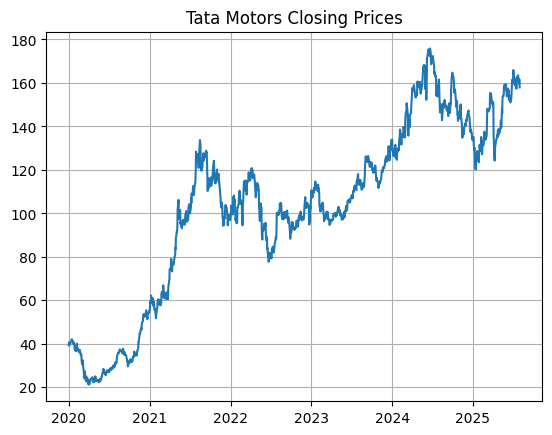

In [4]:
# 📥 Step 1: Download Tata Motors Stock Data
df = yf.download("TATASTEEL.NS", start="2020-01-01", end="2025-08-01")[['Close']].dropna()
plt.plot(df['Close'])
plt.title("Tata Motors Closing Prices")
plt.grid()
plt.show()

In [5]:
# 🧼 Step 2: Preprocess
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
# Create sequences
seq_length = 60
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(seq_length, len(data)):
        xs.append(data[i-seq_length:i])
        ys.append(data[i])
    return np.array(xs), np.array(ys)

X_all, y_all = create_sequences(scaled_data, seq_length)

# 🔀 Train/Test Split: Only last 3 days for test
test_days = 7
X_train, y_train = X_all[:-test_days], y_all[:-test_days]
X_test, y_test = X_all[-test_days:], y_all[-test_days:]

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(StockDataset(X_train, y_train), batch_size=64, shuffle=True)

In [6]:
# 🧠 Step 3: Define LSTM Model with Gate Exposure
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.gates = {}

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        self.gates['hn'] = hn.detach().cpu().numpy()
        self.gates['cn'] = cn.detach().cpu().numpy()
        return self.fc(out[:, -1, :])

class StackedLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(StackedLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2  # Optional regularization between layers
        )

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])


model = StackedLSTM(num_layers=3,hidden_size=128)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
# 🏋️ Step 4: Train Model
epochs = 50
for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.view(-1, seq_length, 1)
        output = model(batch_X)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}")

Epoch 1, Loss: 0.03443
Epoch 2, Loss: 0.00657
Epoch 3, Loss: 0.00277
Epoch 4, Loss: 0.00158
Epoch 5, Loss: 0.00152
Epoch 6, Loss: 0.00210
Epoch 7, Loss: 0.00165
Epoch 8, Loss: 0.00181
Epoch 9, Loss: 0.00149
Epoch 10, Loss: 0.00252
Epoch 11, Loss: 0.00186
Epoch 12, Loss: 0.00068
Epoch 13, Loss: 0.00180
Epoch 14, Loss: 0.00194
Epoch 15, Loss: 0.00081
Epoch 16, Loss: 0.00065
Epoch 17, Loss: 0.00087
Epoch 18, Loss: 0.00095
Epoch 19, Loss: 0.00101
Epoch 20, Loss: 0.00073
Epoch 21, Loss: 0.00123
Epoch 22, Loss: 0.00210
Epoch 23, Loss: 0.00153
Epoch 24, Loss: 0.00068
Epoch 25, Loss: 0.00085
Epoch 26, Loss: 0.00095
Epoch 27, Loss: 0.00104
Epoch 28, Loss: 0.00129
Epoch 29, Loss: 0.00144
Epoch 30, Loss: 0.00074
Epoch 31, Loss: 0.00078
Epoch 32, Loss: 0.00115
Epoch 33, Loss: 0.00127
Epoch 34, Loss: 0.00096
Epoch 35, Loss: 0.00060
Epoch 36, Loss: 0.00074
Epoch 37, Loss: 0.00184
Epoch 38, Loss: 0.00106
Epoch 39, Loss: 0.00058
Epoch 40, Loss: 0.00091
Epoch 41, Loss: 0.00051
Epoch 42, Loss: 0.00083
E

In [8]:
# 🧪 Step 5: Predict Last test_days
model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, seq_length, 1)
    predictions = model(X_tensor).numpy()

predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test)

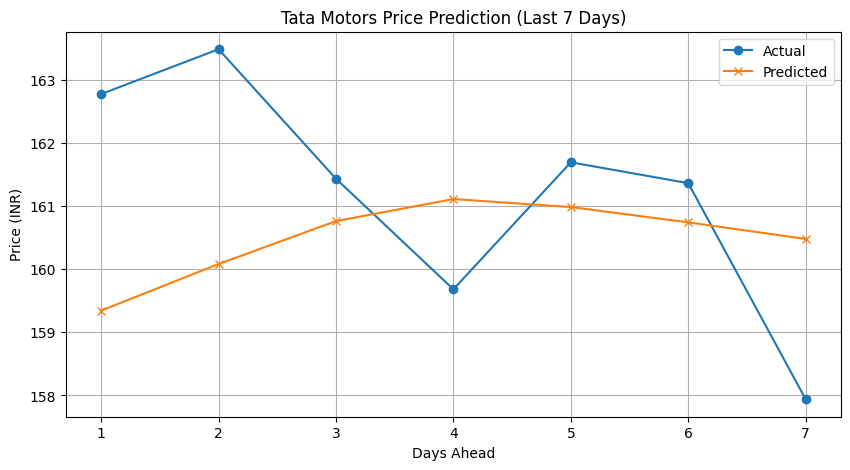

In [9]:
# 📈 Step 6: Plot Predictions
plt.figure(figsize=(10, 5))
plt.plot(range(1, test_days+1), actual_prices, marker='o', label='Actual')
plt.plot(range(1, test_days+1), predicted_prices, marker='x', label='Predicted')
plt.title(f"Tata Motors Price Prediction (Last {test_days} Days)")
plt.xlabel("Days Ahead")
plt.ylabel("Price (INR)")
# plt.xticks([1, 2, 3], labels=["Day -2", "Day -1", "Today"])
plt.legend()
plt.grid()
plt.show()

In [10]:
# 🔬 Step 7: Visualize Hidden & Cell States
hn = model.gates['hn'][0]
cn = model.gates['cn'][0]

plt.figure(figsize=(12, 4))
sns.heatmap(hn, cmap='viridis', annot=False)
plt.title("Hidden State Heatmap (h_t)")
plt.xlabel("Hidden Units")
plt.ylabel("Layer")
plt.show()

plt.figure(figsize=(12, 4))
sns.heatmap(cn, cmap='plasma', annot=False)
plt.title("Cell State Heatmap (c_t)")
plt.xlabel("Cell Units")
plt.ylabel("Layer")
plt.show()

AttributeError: 'StackedLSTM' object has no attribute 'gates'